<a href="https://colab.research.google.com/github/matthiasweidlich/conf_tutorial/blob/master/01_Log_Exploration_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Exercise 1: Event Log Exploration

In this exercise, you will get first insights into the structure of a real-life event log. We are going to use a log which was part of the Business Process Intelligence Challenge 2012 (BPI Challenge 2012). 

**A few details about the scenario of the event log**

The log originates from a Dutch Financial Institute. It contains some 262.200 events in 13.087 cases. Apart from some anonymization, the log contains all data as it came from the financial institute. The process represented in the event log is an application process for a personal loan or overdraft within a global financing organization. The amount requested by the customer is indicated in the case attribute AMOUNT_REQ, which is global, i.e. every case contains this attribute. The event log is a merger of three intertwined sub processes. The first letter of each task name identifies from which sub process (source) it originated from.

In the process, an application is submitted through a webpage. Then, some automatic checks are performed, after which the application is complemented with additional information. This information is obtained trough contacting the customer by phone. If an applicant is eligible, an offer is sent to the client by mail. After this offer is received back, it is assessed. When it is incomplete, missing information is added by again contacting the customer. Then a final assessment is done, after which the application is approved and activated.

**Event type explanation**

| Event Type | Meaning |
| --- | --- | 
| States starting with ‘A_’ | States of the application |
| States starting with ‘O_’ |	States of the offer belonging to the application |
| States starting with ‘W_’ |	States of the work item belonging to the application |
COMPLETE |	The task (of type ‘A_’ or ‘O_’) is completed |
SCHEDULE |	The work item (of type ‘W_’) is created in the queue (automatic step following manual actions)|
START 	| The work item (of type ‘W_’) is obtained by the resource|
COMPLETE |	The work item (of type ‘W_’) is released by the resource and put back in the queue or transferred to another queue (SCHEDULE)|

**Event translation**

| Dutch state name | 	English translation |
| --- | --- | 
|W_Afhandelen leads |	W_Fixing incoming lead|
|W_Completeren aanvraag  |	W_Filling in information for the application|
|W_Valideren aanvraag |	W_Assessing the application|
|W_Nabellen offertes 	| W_Calling after sent offers|
|W_Nabellen incomplete dossiers |	W_Calling to add missing information to the application|



You should be able to clone the repository containing the notebooks and the example data with the code in the next cell. If this does not work, however, you can also download the event log (XES format, please unzip) [here](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge) and then either copy it to your google drive, mount it, and read it from there, or directly upload it using your browser.

In [1]:
# basic configuration
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# import data from google drive
#from google.colab import drive
#drive.mount('/content/drive')

# direct data upload
#from google.colab import files
#files.upload()

# clone the repository that contains the notebooks and also the data file
! git clone https://github.com/matthiasweidlich/conf_tutorial.git
! pip install pmlab_lite

     |████████████████████████████████| 51kB 2.5MB/s 


## Import Event Log


In [1]:
from pmlab_lite.helper.io import xes

log_file = '/content/conf_tutorial/financial_log.xes' # if not in colab or import from different folder: insert path here
log = xes.import_xes(log_file)

100%|██████████| 13087/13087 [01:09<00:00, 188.91it/s]


Now import the given log and inspect the first three traces.

In [2]:
print('Load log with %s traces.' %len(log.traces))
log.print_traces(0,3)

Load log with 13087 traces.
TRACE_ID: 173688 (trace number 0 )
  activity name               time                           transition     
> A_SUBMITTED                 10/01/2011 00:38:44.546000     COMPLETE       
> A_PARTLYSUBMITTED           10/01/2011 00:38:44.880000     COMPLETE       
> A_PREACCEPTED               10/01/2011 00:39:37.906000     COMPLETE       
> W_Completeren aanvraag      10/01/2011 00:39:38.875000     SCHEDULE       
> W_Completeren aanvraag      10/01/2011 11:36:46.437000     START          
> A_ACCEPTED                  10/01/2011 11:42:43.308000     COMPLETE       
> O_SELECTED                  10/01/2011 11:45:09.243000     COMPLETE       
> A_FINALIZED                 10/01/2011 11:45:09.243000     COMPLETE       
> O_CREATED                   10/01/2011 11:45:11.197000     COMPLETE       
> O_SENT                      10/01/2011 11:45:11.380000     COMPLETE       
> W_Nabellen offertes         10/01/2011 11:45:11.554000     SCHEDULE       
> W_Completer

## Section 1: Traces
Each log contains at least one trace. Each trace again consists of events. In the first section, you will inspect several trace properties, like trace length, trace variants and more.

### Trace length
A trace consists of events. The number of events in a trace defines its length. The code snippet below computes the length of the shortest and the longest trace in the log.

In [3]:
max_length = 0
min_length = 1000

for trace in log.get_traces():
    if len(trace) > max_length:
        max_length = len(trace)
        
    if len(trace) < min_length:
        min_length = len(trace)

print('The longest trace contains %s events. The shortest trace: %s events.' %(max_length, min_length))

The longest trace contains 175 events. The shortest trace: 3 events.


**Task**: Compute the length of all traces in the log. Use a histogram to visualize your findings.

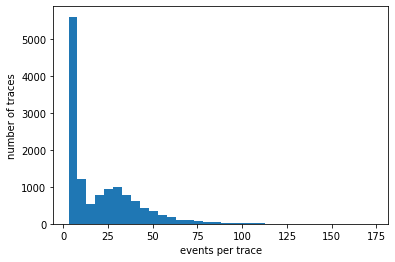

In [4]:
import matplotlib.pyplot as plt

trace_length = []

for trace in log.get_traces():
    trace_length.append(len(trace))
    

plt.hist(trace_length, bins=range(min_length, max_length, 5))
plt.xlabel('events per trace')
plt.ylabel('number of traces')
plt.show()

### Trace variants
A trace can be seen as a sequence of events. Since the same sequence of event classes may occur multiple times in the same log, it might be interesting to know how many different traces exist. Such different traces are called trace variants. The code snippet below computes all trace variants in the log:

In [5]:
trace_list = []

for trace in log.get_traces():
    events = []
    for event in trace:
        events.append(event['concept:name'])
        
    trace_list.append(tuple(events))

trace_variants = set(trace_list)

print('The log contains %s trace variants.' %len(trace_variants))


The log contains 4366 trace variants.


### Trace variant frequency

**Task**: Compute the frequency of each trace variant in the log.

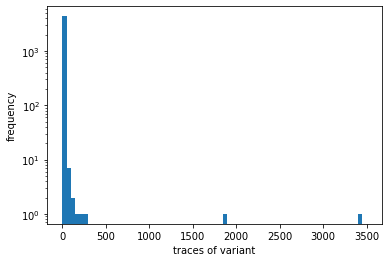

In [6]:
from collections import Counter
counter = [1]

counter = (Counter(trace_list).values())
# counter.sort(reverse=True)
# print(counter)
 
plt.hist(counter, bins=range(min(counter), max(counter)+100, 50))
plt.xlabel('traces of variant')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

**Task**: Which variant is the most frequent one?

In [7]:
Counter(trace_list).most_common()[0]


(('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED'), 3429)

### Trace duration
Events may have several attributes like a timestamp or a resource. We can use these timestamps to compute the duration of a single trace. The following code returns the shortest and longest duration of all traces in the log.

In [8]:
from datetime import datetime, timedelta


max_duration = timedelta(microseconds=1)
min_duration = timedelta(days=10000)

for trace in log.get_traces():
    
    # we only need to consider the first and last event in the trace
    first_e = trace[0]
    last_e = trace[-1]
    
    t0 = first_e['time:timestamp']
    t1 = last_e['time:timestamp']
    duration = t1 - t0
    
    if duration > max_duration:
        max_duration = duration
    elif duration < min_duration:
        min_duration = duration
        
print('The shortest process instance took %s; the longest %s' %(min_duration, max_duration))

The shortest process instance took 0:00:01.855000; the longest 137 days, 5:18:56.012000


**Task:** Compute the duration of each trace in seconds in the log and visualize the result in a histogram. *Hint*: use the method `total_seconds()` to obtain the number of seconds from a duration object.

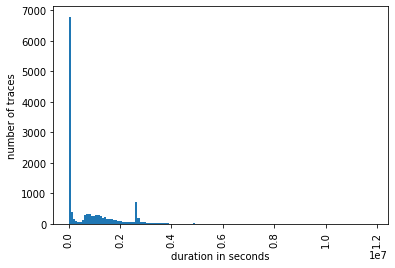

In [9]:
durations = []

for trace in log.get_traces():
    first_e = trace[0]
    last_e = trace[-1]
    
    t0 = first_e['time:timestamp']
    t1 = last_e['time:timestamp']
    durations.append((t1 - t0).total_seconds())
    
plt.hist(durations, bins=range(0, round(max(durations)), 86400))
ax = plt.gca()
plt.xticks(rotation='vertical')
plt.xlabel('duration in seconds')
plt.ylabel('number of traces')
plt.show()

### Trace start days
We can use timestamps to get even more insights. For example, it might be interesting to know at which weekday the most process instances start. 

**Task:** Extract for all traces the day of the week at which the instance was started and visualize the results in a histogram. *Hint*: use `isoweekday()` to get the weekday of an datetime object.

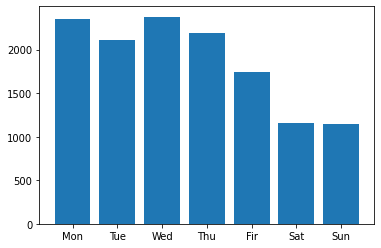

In [10]:
import numpy as np

weekdays = []

for trace in log.get_traces():
    first_e = trace[0]
    t0 = first_e['time:timestamp']
    weekdays.append(t0.isoweekday())
    
data = np.bincount(weekdays)[1:]
x_ticks = range(0,7)
plt.bar(x_ticks, data)
ax = plt.gca()
ax.set_xticks(x_ticks)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fir', 'Sat', 'Sun'])
plt.show()

## Section 2: Events
So far, you got some insights into the trace level of the event log. Now, we will have a closer look at the individual events.

### Events in the log
**Task**: Get the total number of events in the log.

In [11]:
   print('The log contains %s events.' %len(log.events))

The log contains 262200 events.


### Event classes
Events may refer to different lifecycle states of activity execution. For example, the execution of an activity *A* can be scheduled, started and finally be completed. Here, the lifecycle of executing activity *A* has three states. Each state transition in such a lifecycle of activity execution can be considered as a separate event class. For example, "an activity of name A being started" and "an activity of name A being scheduled" are then two separate event classes.

**Task**: Get the number of event classes based on information about the executed activity and the lifecycle transition and print out all identified event classes.

In [12]:
from pprint import pprint


event_classes = set()

for trace in log.get_traces():
    for event in trace:
        event_classes.add((event['concept:name'], event['lifecycle:transition']))


print('The log contains %s event classes.' %len(event_classes))
pprint(event_classes)

The log contains 36 event classes.
{('A_ACCEPTED', 'COMPLETE'),
 ('A_ACTIVATED', 'COMPLETE'),
 ('A_APPROVED', 'COMPLETE'),
 ('A_CANCELLED', 'COMPLETE'),
 ('A_DECLINED', 'COMPLETE'),
 ('A_FINALIZED', 'COMPLETE'),
 ('A_PARTLYSUBMITTED', 'COMPLETE'),
 ('A_PREACCEPTED', 'COMPLETE'),
 ('A_REGISTERED', 'COMPLETE'),
 ('A_SUBMITTED', 'COMPLETE'),
 ('O_ACCEPTED', 'COMPLETE'),
 ('O_CANCELLED', 'COMPLETE'),
 ('O_CREATED', 'COMPLETE'),
 ('O_DECLINED', 'COMPLETE'),
 ('O_SELECTED', 'COMPLETE'),
 ('O_SENT', 'COMPLETE'),
 ('O_SENT_BACK', 'COMPLETE'),
 ('W_Afhandelen leads', 'COMPLETE'),
 ('W_Afhandelen leads', 'SCHEDULE'),
 ('W_Afhandelen leads', 'START'),
 ('W_Beoordelen fraude', 'COMPLETE'),
 ('W_Beoordelen fraude', 'SCHEDULE'),
 ('W_Beoordelen fraude', 'START'),
 ('W_Completeren aanvraag', 'COMPLETE'),
 ('W_Completeren aanvraag', 'SCHEDULE'),
 ('W_Completeren aanvraag', 'START'),
 ('W_Nabellen incomplete dossiers', 'COMPLETE'),
 ('W_Nabellen incomplete dossiers', 'SCHEDULE'),
 ('W_Nabellen incomple

### Event schedule
We already computed how many process instances started at which day of the week. We can do the same for each event class. 

**Task:** Use the code snippet below as a starting point. *Hint:* use the methods `get_timestamp()` and `isoweekday()`.

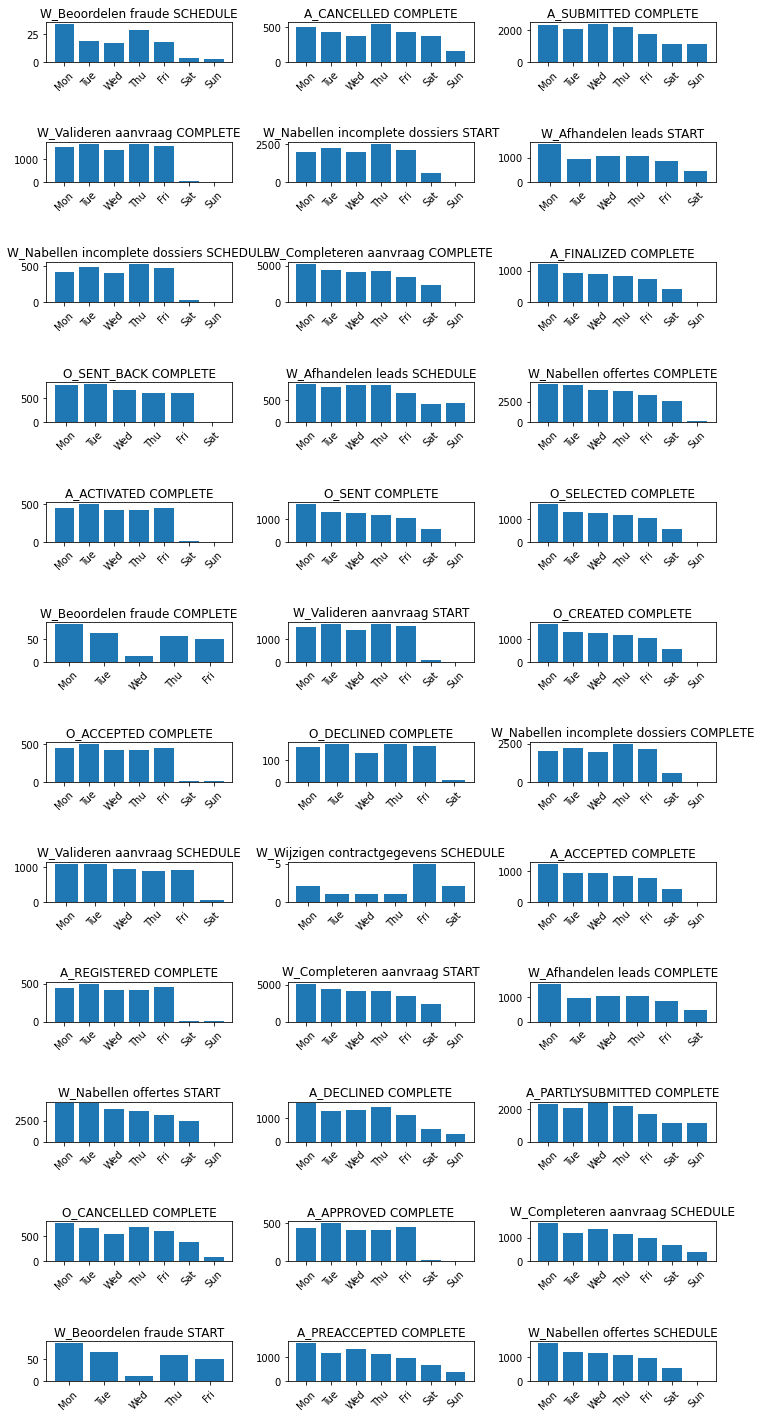

In [13]:
# setup subplots
fig, ax = plt.subplots(12, 3, figsize=(12, 25))
fig.subplots_adjust(hspace = 2, wspace=0.3)
ax = ax.flatten()

for idx, target_event in enumerate(list(event_classes)):
    weekdays = []
    
    for trace in log.get_traces():
        for event in trace:
            if event['concept:name'] == target_event[0] and event['lifecycle:transition'] == target_event[1]:
                t0 = event['time:timestamp']
                weekdays.append(t0.isoweekday())

    
    # plot
    data = np.bincount(weekdays)[1:]
    
    x_ticks = range(0,len(data), 1)
    ax[idx].bar(x_ticks, data)
    ax[idx].set_xticks(x_ticks)
    ax[idx].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
    ax[idx].set_title(target_event[0] + ' ' + target_event[1])
    
plt.show()

### Event resource assignments
Sometimes an event is processed by a resource. Possible resources are machines and employees. The used resource can be specified in the events attributes.

**Task:** How many different resources are used across the process instances?

In [14]:
resources = []

for trace in log.get_traces():
  for event in trace:
    resources.append(event.get('org:resource', None))
print('All process instances use %s different resource in total' % len(set(resources)))

All process instances use 69 different resource in total


**Task**: Are all events processed by a resource? If not, compute the ratio of events that are processed by a resource.

In [15]:
no_res = resources.count(None)

print('%.2f%% of all events are processed by a resource.' %(((len(resources)-no_res)/len(resources))*100 ))

93.13% of all events are processed by a resource.


## -- End